In [1]:
import pandas as pd
import os

# work_dir = "../input/mnist-rotation"
work_dir = "../Task 2 Mnist rotation"
os.listdir(work_dir)

['sample_submission.csv',
 'solution.ipynb',
 'submission.csv',
 'test.pkl',
 'train.pkl']

In [4]:
import matplotlib.pylab as plt
import numpy as np
from scipy.ndimage import rotate as scipy_rotate


def show_image(image, title=None):
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    if title is not None:
        plt.title(title)
    plt.show()

def rotate(img: np.ndarray, angle: int) -> np.ndarray:
    if not (-120 <= angle <= 120):
        raise ValueError("Angle must be between -120 and 120 degrees.")
    
    rotated_img = scipy_rotate(
        img,
        angle=angle,
        reshape=False,      # сохраняем размер 28x28
        order=1,            # билинейная интерполяция для аккуратного поворота
        mode='constant',    # пиксели вне исходного изображения заполняются константой
        cval=0.0            # заполняем черным (0)
    )
    return rotated_img

# Мы покажем вам как на тесте наши враги зашумляли наши картинки

Теперь вы тоже можете делать это!

In [5]:
class NoizeGenerator:
    def __init__(
        self,
        discrete_noise_proba=0.02,
        beta_alpha=0.3,
        beta_beta=0.3,
        gaussian_sigma=0.0,
        shift_prob=1.0,
        seed=None,
    ):
        """
        discrete_noise_proba: вероятность заменить пиксель значением из бета-распределения
        beta_alpha, beta_beta: параметры бета-распределения (бимодальность при < 1)
        gaussian_sigma: стандартное отклонение для нормального шума
        shift_prob: вероятность случайного сдвига изображения на 1 пиксель
        """
        self.discrete_noise_proba = discrete_noise_proba
        self.beta_alpha = beta_alpha
        self.beta_beta = beta_beta
        self.gaussian_sigma = gaussian_sigma
        self.shift_prob = shift_prob
        self.rng = np.random.default_rng(seed)

    def apply_beta_noise(self, img):
        mask = self.rng.random(img.shape) < self.discrete_noise_proba
        beta_noise = (
            self.rng.beta(self.beta_alpha, self.beta_beta, size=img.shape) * 255
        )
        noisy_img = img.copy()
        noisy_img[mask] = beta_noise[mask]
        return noisy_img

    def apply_gaussian_noise(self, img):
        if self.gaussian_sigma > 0:
            noise = self.rng.normal(loc=0.0, scale=self.gaussian_sigma, size=img.shape)
            img = img + noise
            img = np.clip(img, 0, 255)
        return img

    def apply_random_shift(self, img):
        direction = self.rng.choice(["up", "down", "left", "right"])
        shifted = np.zeros_like(img)

        if direction == "up":
            shifted[:-1, :] = img[1:, :]
        elif direction == "down":
            shifted[1:, :] = img[:-1, :]
        elif direction == "left":
            shifted[:, :-1] = img[:, 1:]
        elif direction == "right":
            shifted[:, 1:] = img[:, :-1]

        return shifted

    def transform_image(self, image):
        tmp_image = image.astype(np.float32)
        tmp_image = self.apply_beta_noise(tmp_image)
        tmp_image = self.apply_gaussian_noise(tmp_image)

        if self.rng.random() < self.shift_prob:
            tmp_image = self.apply_random_shift(tmp_image)
        return tmp_image.astype(np.uint8)

    def transform_dataset(self, X):
        n_samples = X.shape[0]
        X_aug = np.zeros_like(X)

        for i in range(n_samples):
            img = self.transform_image(X[i].reshape(28, 28))
            X_aug[i] = img.flatten()
        return X_aug
    

noize_gen = NoizeGenerator(
    discrete_noise_proba=0.2,
    beta_alpha=0.3,
    beta_beta=0.3,
    gaussian_sigma=40,
    shift_prob=1.0,
    seed=1,
)

# Такие данные доступны нам на трейне!

In [6]:
train = pd.read_pickle(os.path.join(work_dir, 'train.pkl'))
train.head()

,image,label,angle
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",6,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",9,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4,0


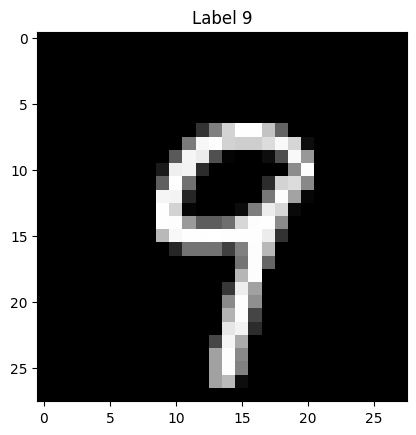

In [7]:
show_image(train.image.iloc[1], title=f"Label {train.label.iloc[1]}")

# Вот так мы можем на них пошуметь

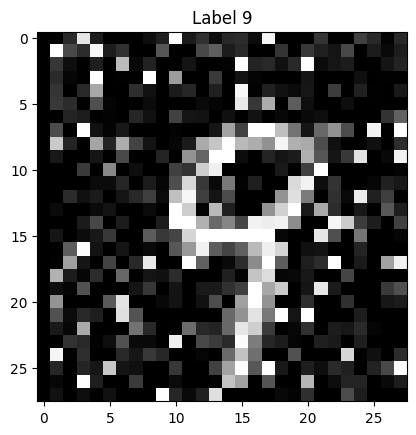

In [8]:
show_image(noize_gen.transform_image(train.image.iloc[1]), title=f"Label {train.label.iloc[1]}")

# А такие данные у вас на тесте

На тесте наши враги взяли картинки похожие на наши - но сначала повернули их - а потом еще и зашумили

Ваша задача - для каждой тестовой картинки предсказать угол ее поворота

Эта задача довольно сложная потому что рукописные картинки могут быть повернуты изначально

Однако ваша задача - **определить угол искусственного поворота**

In [9]:
test = pd.read_pickle(os.path.join(work_dir, 'test.pkl'))
test.head()

,ID,image,label,angle
0,0,"[[0, 55, 0, 0, 17, 17, 40, 0, 12, 0, 0, 0, 0, ...",2,0
1,1,"[[124, 255, 0, 0, 79, 44, 51, 0, 183, 5, 0, 78...",2,0
2,2,"[[196, 1, 0, 0, 0, 0, 0, 0, 33, 0, 0, 4, 0, 64...",3,0
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,0
4,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,0


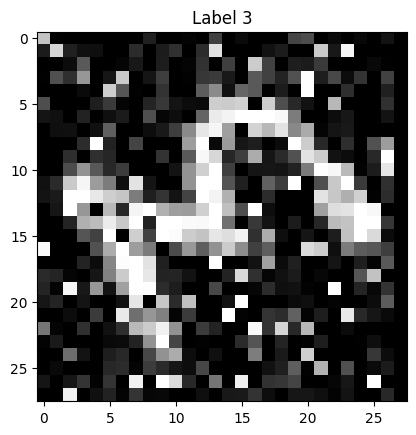

In [10]:
show_image(test.image.iloc[2], title=f"Label {test.label.iloc[2]}")

# Вот так выглядят эти картинки под разными углами

In [ ]:
allowed_angles = np.arange(-120, 121, 30)

print(f"Разрешенные углы поворота: {allowed_angles}")

# for angle in allowed_angles:
    # show_image(rotate(test.image.iloc[2], angle), title=f"Label {test.label.iloc[2]}, Angle: {angle}")

Разрешенные углы поворота: [-120  -90  -60  -30    0   30   60   90  120]


# Вот так выглядит sample submission

каждое значение колонки ID совпадает с соответствующей картинки из test.pkl

In [108]:
sample_submission = pd.read_csv(os.path.join(work_dir, 'sample_submission.csv'))
sample_submission

,ID,angle
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
149995,149995,0
149996,149996,0
149997,149997,0
149998,149998,0


In [18]:
test.head(2)

,ID,image,label,angle
0,0,"[[0, 55, 0, 0, 17, 17, 40, 0, 12, 0, 0, 0, 0, ...",2,0
1,1,"[[124, 255, 0, 0, 79, 44, 51, 0, 183, 5, 0, 78...",2,0


In [35]:
find_new = {allowed_angles[i]: i for i in range(len(allowed_angles))}
find_new

{np.int64(-120): 0,
 np.int64(-90): 1,
 np.int64(-60): 2,
 np.int64(-30): 3,
 np.int64(0): 4,
 np.int64(30): 5,
 np.int64(60): 6,
 np.int64(90): 7,
 np.int64(120): 8}

In [128]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [127]:
def change(batch, angle):
    res = []
    for x in batch:
        res.append(noize_gen.transform_image(rotate(x, angle)))
    return np.array(res)

- Идея моего решения в том, чтобы научить модель распознавать угол поворота для каждой цифры отдельно.
Для этого я беру исходные изображения из тренировочного набора и искусственно поворачиваю их на все возможные углы, создавая таким образом полный набор примеров для обучения.

- После этого XGBClassifier обучается определять, на какой угол повернута цифра, а затем используется для тестовых изображений, чтобы предсказать реальный угол поворота каждой цифры с учётом шума и наклона написания.

In [132]:
labels = np.array([i for i in range(0, 10)])
parts = []
for k in labels:
    train_k = np.array(train[train.label == k].image.tolist())
    idx = test[test.label == k].ID.tolist()
    X_test = np.array(test[test.label == k].image.tolist())
    X_train = np.array([])
    y_train = np.array([])
    for angle in allowed_angles:
        new_train = change(train_k, angle)
        new_y = [find_new[angle] for i in range(new_train.shape[0])]
        if angle == -120:
            X_train = new_train
            y_train = new_y
        else:
            X_train = np.concat([X_train, new_train], axis = 0)
            y_train = np.concat([y_train, new_y], axis = 0)
    X_train = X_train.reshape(X_train.shape[0], 28*28)
    X_test = X_test.reshape(X_test.shape[0], 28*28)
    model = XGBClassifier(random_state=228)
    model.fit(X_train, y_train)
    prediction = np.array(model.predict(X_test))
    prediction = (prediction - 4) * 30
    y_k = pd.DataFrame({'ID': idx, 'angle': prediction})
    parts.append(y_k)


In [133]:
final = pd.concat(parts, axis = 0)
final = final.sort_values(by=['ID'])
final.to_csv('submission.csv', index=False)
final


,ID,angle
0,0,60
1,1,90
0,2,120
2,3,30
0,4,90
...,...,...
15194,149995,90
15598,149996,120
16787,149997,60
15599,149998,60
